# Usage

`liana` contains different statistical methods to infer `ligand-receptor` interactions from single-cell transcriptomics data omics data using prior knowledge.
In this notebook we showcase how to use liana in its' most basic form with toy data.

<div class="alert alert-info">

**Note**
    
In Jupyter notebooks and lab, you can see the documentation for a python function by hitting `SHIFT + TAB`, hit it twice to expand the view, or by typing `?name_of_function`.

</div>  

## Loading Packages

In [1]:
import liana as li

# Only needed for visualization:
import matplotlib.pyplot as plt
from scanpy.pl import umap

# toy data
from scanpy.datasets import pbmc68k_reduced
%matplotlib inline

## Loading toy data

`liana` uses `anndata` objects with processed single-cell (*and soon spatial*) transcriptomics data, with pre-defined cell labels (identities), to predict ligand-receptor interactions among all pairs of cell identities.

To load the example data-set, simply run:

In [2]:
adata = pbmc68k_reduced()

The example single-cell data consists processed data with PBMCs cell types

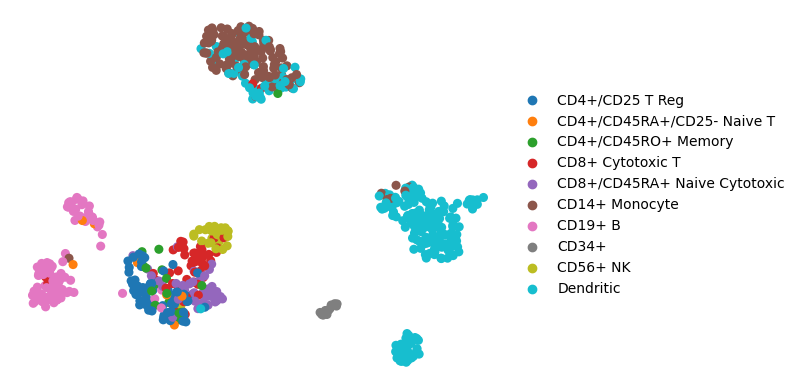

In [3]:
umap(adata, color='bulk_labels', title='', frameon=False)

## Background

In the most basic scenario, `liana` works with the log-trasformed counts matrix, in this object the normalized counts are stored in `raw`:

In [4]:
adata.raw.X

<700x765 sparse matrix of type '<class 'numpy.float32'>'
	with 174400 stored elements in Compressed Sparse Row format>

Preferably, one would use `liana` with all features (genes) for which we have enough counts, but for the sake of this tutorial we are working with a matrix pre-filtered to the variable features alone.

In the background, `liana` aggregates the counts matrix and generates statistics, typically related to cell identies.
These statistics are then utilized by each of the methods in `liana`.

### Methods

In [5]:
li.show_methods()

,Method Name,Magnitude Score,Specificity Score,Reference
0,CellPhoneDB,lr_means,pvals,"Efremova, M., Vento-Tormo, M., Teichmann, S.A...."
0,Connectome,expr_prod,scaled_weight,"Raredon, M.S.B., Yang, J., Garritano, J., Wang..."
0,log2FC,None,lr_logfc,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,NATMI,expr_prod,spec_weight,"Hou, R., Denisenko, E., Ong, H.T., Ramilowski,..."
0,SingleCellSignalR,lrscore,None,"Cabello-Aguilar, S., Alame, M., Kon-Sun-Tack, ..."
0,Rank_Aggregate,magnitude_rank,specificity_rank,"Kolde, R., Laur, S., Adler, P. and Vilo, J., 2..."


Each method infers relevant ligand-receptor interactions relying on different assumptions, and each returns different ligand-receptor scores, typically a pair per method. One score corresponding to
the `magnitude` (strength) of interaction and the other reflecting how `specificity` of a given interaction to a pair cell identities.

<div class="alert alert-info">

<h4> Method Class</h4>
    
Methods in liana are **callable** instances of the `Method` class. To obtain further information for each method the user can refer to the methods documentation `?method_name` or `?method.__call__`. Alternatively, users can use the `method.describe` function to get a short summary for each method.

</div>  


For example, if the user wishes to learn more about liana's `rank_aggregate` implementation, where we combine the scores of multiple methods, they could do the following: 

In [6]:
# import liana's rank_aggregate
from liana import rank_aggregate

In [7]:
?rank_aggregate.__call__

Signature:
rank_aggregate.__call__(
    adata: anndata._core.anndata.AnnData,
    groupby: str,
    resource_name: str = 'consensus',
    expr_prop: float = 0.1,
    base: float = 2.718281828459045,
    aggregate_method='rra',
    consensus_opts=None,
    use_raw: Union[bool, NoneType] = False,
    layer: Union[str, NoneType] = None,
    de_method='t-test',
    verbose: Union[bool, NoneType] = False,
    n_perms: int = 1000,
    seed: int = 1337,
    resource: Union[pandas.core.frame.DataFrame, NoneType] = None,
    copy=False,
) -> anndata._core.anndata.AnnData
Docstring:
Parameters
----------
adata
    Annotated data object.
groupby
    The key of the observations grouping to consider.
resource_name
    Name of the resource to be loaded and use for ligand-receptor inference.
expr_prop
    Minimum expression proportion for the ligands/receptors (and their subunits) in the
     corresponding cell identities. Set to `0`, to return unfiltered results.
base
    Exponent base used to rever

or alternatively:

In [8]:
rank_aggregate.describe()

Rank_Aggregate uses `magnitude_rank` and `specificity_rank` as measures of expression strength and interaction specificity, respectively


#### Resources

To provide ligand-receptor predictions `liana` relies on prior-knowledge and makes use of the following ligand-receptor resources:

In [9]:
li.show_resources()

['baccin2019',
 'cellcall',
 'cellchatdb',
 'cellinker',
 'cellphonedb',
 'celltalkdb',
 'connectomedb2020',
 'consensus',
 'embrace',
 'guide2pharma',
 'hpmr',
 'icellnet',
 'italk',
 'kirouac2010',
 'lrdb',
 'ramilowski2015']

These were pre-generated using the [OmniPath](https://github.com/saezlab/omnipath) meta-database, but any custom resource can also be passed.
We refer the user to [OmniPath](https://github.com/saezlab/omnipath) as a useful tool to build any resource.

<div class="alert alert-info">
    
By default, `liana` uses the `consensus` resource, which is composed by multiple expert-curated ligand-receptor resources, including CellPhoneDB, CellChat, ICELLNET, connectomeDB2020, and CellTalkDB.
</div>  


## Example Run

### Individual Methods

In [10]:
# import indivudla methods
from liana import singlecellsignalr, connectome, cellphonedb, natmi, logfc

In [11]:
# run cellphonedb
adata = cellphonedb(adata, groupby='bulk_labels', use_raw=True)

By default, results will be assigned to `adata.uns['liana_res']`

In [12]:
# by default, liana's output is saved in place:
adata.uns['liana_res'].head()

,ligand,ligand_complex,ligand_means,ligand_props,ligand_pvals,receptor,receptor_complex,receptor_means,receptor_props,receptor_pvals,source,target,lr_means,pvals
0,HLA-DRA,HLA-DRA,0.625279,0.323529,6.174542e-36,CD4,CD4,0.295691,0.220588,0.763434,CD4+/CD25 T Reg,CD4+/CD25 T Reg,0.460485,1.0
1,HLA-DQA2,HLA-DQA2,0.196956,0.117647,4.070233e-37,CD4,CD4,0.295691,0.220588,0.763434,CD4+/CD25 T Reg,CD4+/CD25 T Reg,0.246324,1.0
2,HLA-DQA1,HLA-DQA1,0.253897,0.161765,4.804243e-42,CD4,CD4,0.295691,0.220588,0.763434,CD4+/CD25 T Reg,CD4+/CD25 T Reg,0.274794,1.0
3,HLA-DRB1,HLA-DRB1,0.853603,0.382353,2.758348e-24,CD4,CD4,0.295691,0.220588,0.763434,CD4+/CD25 T Reg,CD4+/CD25 T Reg,0.574647,1.0
4,HLA-DQB1,HLA-DQB1,0.401779,0.279412,3.516375e-26,CD4,CD4,0.295691,0.220588,0.763434,CD4+/CD25 T Reg,CD4+/CD25 T Reg,0.348735,1.0


Here, we see that generic stats are provided for both `ligand_` and `receptor` *entities*, more specifically:
- `ligand` and `receptor` are typically the two entities that interact. Though it should be noted that these are not limited to secreted signalling. Also, in the case of heteromeric complexes, these represent the subunit with minimum expression, while `*_complex` corresponds to the actual complex, and is hence the unique key for each row. 
- `source` and `target` columns represent the `source/sender` and `target/receiver` cell identity for each interaction, respectively
- `*_props`: represents the proportion of cells that express the entity
- `*_pvals`: 1vsRest p-value calculated at the single-cell level
- `*_means`: entity expression mean per cell type
- `lr_means`: mean ligand-receptor expression, as a measure of ligand-receptor interaction magnutde
- `pvals`: permutation-based p-value, as a measure of interaction specificity

Note that `ligand`, `receptor`, `source`, `target` columns are returned by every method, while the rest can vary.

### Rank Aggregate
In addition to the individual methods, LIANA also provides a consensus that integrates the predictions of individual methods.
This is done by ranking and aggregating ([RRA](https://academic.oup.com/bioinformatics/article-abstract/28/4/573/213339)) the ligand-receptor interaction predictions from all methods.

In [13]:
# import rank_aggregate methods
from liana import rank_aggregate

In [14]:
# Run method
adata = rank_aggregate(adata, groupby='bulk_labels', use_raw=True, expr_prop=0)

In [15]:
adata.uns['liana_res'].head()

,source,target,ligand_complex,receptor_complex,lr_means,pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,magnitude_rank,specificity_rank,steady_rank
3726,CD56+ NK,CD56+ NK,SPON2,ITGB2,1.948322,0.0,3.710696,1.867642,1.860055,0.121435,0.763774,0.004516,0.000007,8.368476e-08
2466,CD56+ NK,CD14+ Monocyte,SPON2,ITGB2,1.873937,0.0,3.464283,1.789787,1.860121,0.113371,0.757519,0.006456,0.000012,1.633739e-07
4146,CD56+ NK,Dendritic,SPON2,ITGB2,1.714034,0.0,2.934582,1.622428,1.578404,0.096036,0.741955,0.015343,0.000055,1.300030e-06
1649,Dendritic,CD8+ Cytotoxic T,HLA-DRA,LAG3,2.468592,0.0,1.812805,0.967507,1.591740,0.119286,0.693240,0.002375,0.000010,1.756732e-06
2337,CD14+ Monocyte,CD14+ Monocyte,ICAM4,ITGB2,1.469182,0.0,1.771155,0.810995,1.236252,0.115416,0.690763,0.053213,0.000080,2.170966e-06


### Dotplot

In [64]:
?np.sort

Signature: np.sort(a, axis=-1, kind=None, order=None)
Docstring:
Return a sorted copy of an array.

Parameters
----------
a : array_like
    Array to be sorted.
axis : int or None, optional
    Axis along which to sort. If None, the array is flattened before
    sorting. The default is -1, which sorts along the last axis.
kind : {'quicksort', 'mergesort', 'heapsort', 'stable'}, optional
    Sorting algorithm. The default is 'quicksort'. Note that both 'stable'
    and 'mergesort' use timsort or radix sort under the covers and, in general,
    the actual implementation will vary with data type. The 'mergesort' option
    is retained for backwards compatibility.

    .. versionchanged:: 1.15.0.
       The 'stable' option was added.

order : str or list of str, optional
    When `a` is an array with fields defined, this argument specifies
    which fields to compare first, second, etc.  A single field can
    be specified as a string, and not all fields need be specified,
    but unspecif

In [61]:
my_p = li.pl.dotplot(adata, 
                     colour='lrscore',
                     size='steady_rank',
                     source_labels=['CD34+', 'CD56+ NK', 'CD14+ Monocyte'],
                     target_labels=['CD34+', 'CD56+ NK', 'CD4+/CD25 T Reg'],
                     top_n=20, 
                     orderby='steady_rank',
                     figure_size=(5, 5))

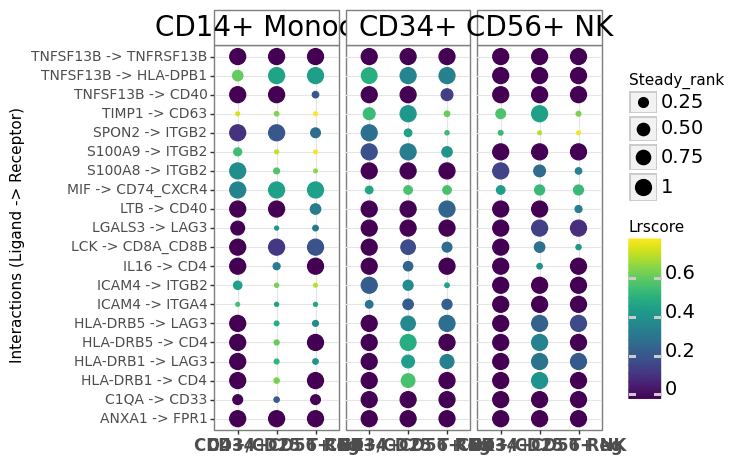

<ggplot: (8772703898585)>

In [62]:
my_p

In [59]:
adata.obs.bulk_labels.cat.categories

Index(['CD4+/CD25 T Reg', 'CD4+/CD45RA+/CD25- Naive T', 'CD4+/CD45RO+ Memory',
       'CD8+ Cytotoxic T', 'CD8+/CD45RA+ Naive Cytotoxic', 'CD14+ Monocyte',
       'CD19+ B', 'CD34+', 'CD56+ NK', 'Dendritic'],
      dtype='object')

In [38]:
source_labels = None
target_labels = None
inverse_colour = False
inverse_size = False
top_n = None
colour='lrscore'
size='steady_rank'
top_n=20
orderby='steady_rank'
figure_size=(5, 5)

In [39]:
from plotnine import ggplot, geom_point, aes, \
    facet_grid, labs, theme_bw, theme, element_text, element_rect
import numpy as np

In [40]:
def _aggregate_scores(res, what, how, entities):
    return res.groupby(entities).agg(score=(what, how)).reset_index()

def _inverse_scores(score):
    return -np.log10(score + np.finfo(float).eps)

In [41]:
# extract results & create interaction col
liana_mod = adata.uns['liana_res'].copy()
liana_mod['interaction'] = liana_mod.ligand_complex + ' -> ' + liana_mod.receptor_complex

In [42]:
liana_mod

,source,target,ligand_complex,receptor_complex,lr_means,pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,magnitude_rank,specificity_rank,steady_rank,interaction
3726,CD56+ NK,CD56+ NK,SPON2,ITGB2,1.948322,0.0,3.710696,1.867642,1.860055,0.121435,0.763774,0.004516,0.000007,8.368476e-08,SPON2 -> ITGB2
2466,CD56+ NK,CD14+ Monocyte,SPON2,ITGB2,1.873937,0.0,3.464283,1.789787,1.860121,0.113371,0.757519,0.006456,0.000012,1.633739e-07,SPON2 -> ITGB2
4146,CD56+ NK,Dendritic,SPON2,ITGB2,1.714034,0.0,2.934582,1.622428,1.578404,0.096036,0.741955,0.015343,0.000055,1.300030e-06,SPON2 -> ITGB2
1649,Dendritic,CD8+ Cytotoxic T,HLA-DRA,LAG3,2.468592,0.0,1.812805,0.967507,1.591740,0.119286,0.693240,0.002375,0.000010,1.756732e-06,HLA-DRA -> LAG3
2337,CD14+ Monocyte,CD14+ Monocyte,ICAM4,ITGB2,1.469182,0.0,1.771155,0.810995,1.236252,0.115416,0.690763,0.053213,0.000080,2.170966e-06,ICAM4 -> ITGB2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1789,CD4+/CD45RO+ Memory,CD8+/CD45RA+ Naive Cytotoxic,LTB,CD40,0.000000,1.0,0.000000,0.005921,-0.007284,0.000000,0.000000,1.000000,1.000000,1.000000e+00,LTB -> CD40
1791,CD4+/CD45RO+ Memory,CD8+/CD45RA+ Naive Cytotoxic,ICAM4,ITGB2,0.000000,1.0,0.000000,-0.507073,-0.919597,0.000000,0.000000,1.000000,1.000000,1.000000e+00,ICAM4 -> ITGB2
1792,CD4+/CD45RO+ Memory,CD8+/CD45RA+ Naive Cytotoxic,S100A8,ITGB2,0.000000,1.0,0.000000,-0.501615,-0.952432,0.000000,0.000000,1.000000,1.000000,1.000000e+00,S100A8 -> ITGB2
1794,CD4+/CD45RO+ Memory,CD8+/CD45RA+ Naive Cytotoxic,SPON2,ITGB2,0.469191,1.0,0.052444,-0.397525,-0.738336,0.001716,0.277654,0.658080,1.000000,1.000000e+00,SPON2 -> ITGB2


In [43]:
# subset to only cell labels of interest
if source_labels is not None:
    source_msk = np.isin(liana_mod.source, source_labels)
    liana_mod = liana_mod[source_msk]
if target_labels is not None:
    target_msk = np.isin(liana_mod.target, target_labels)
    liana_mod = liana_mod[target_msk]

In [44]:
_inverse_scores(liana_mod[size])

3726    7.077354e+00
2466    6.786817e+00
4146    5.886047e+00
1649    5.755294e+00
2337    5.663347e+00
            ...     
1789   -9.643275e-17
1791   -9.643275e-17
1792   -9.643275e-17
1794   -9.643275e-17
2099   -9.643275e-17
Name: steady_rank, Length: 4200, dtype: float64

In [45]:
# inverse sc if needed
if inverse_colour:
    liana_mod[colour] = _inverse_scores(liana_mod[colour])
if inverse_size:
    liana_mod[size] = _inverse_scores(liana_mod[size])


In [46]:
top_lrs = _aggregate_scores(liana_mod, what=orderby, how='min',
                                entities=['interaction', 'ligand_complex', 'receptor_complex'])

In [47]:
top_lrs.sort_values('score', ascending=False).head(top_n).interaction

32        MIF -> CD74_CXCR4
28              IL16 -> CD4
3            CD40LG -> CD40
5             GNAI2 -> FPR1
38         TNFSF13B -> CD40
6            GNAI2 -> S1PR4
40    TNFSF13B -> TNFRSF13B
26           ICAM4 -> ITGA4
7            GNAI2 -> S1PR5
30           LGALS3 -> LAG3
41     TNFSF13B -> TNFRSF17
4            CD40LG -> CD53
25         HLA-DRB5 -> LAG3
29         LCK -> CD8A_CD8B
35           SPON2 -> ITGA4
31              LTB -> CD40
33          S100A8 -> ITGB2
34          S100A9 -> ITGB2
22          HLA-DRB1 -> CD4
37            TIMP1 -> CD63
Name: interaction, dtype: object

In [48]:
if top_n is not None:
    # get the max for each interaction
    top_lrs = _aggregate_scores(liana_mod, what=orderby, how='min',
                                entities=['interaction', 'ligand_complex', 'receptor_complex'])
    top_lrs = top_lrs.sort_values('score', ascending=True).head(top_n).interaction
    # Filter liana_res to the interactions in top_lrs
    liana_mod = liana_mod[liana_mod.interaction.isin(top_lrs)]

In [52]:
liana_mod

,source,target,ligand_complex,receptor_complex,lr_means,pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,magnitude_rank,specificity_rank,steady_rank,interaction
3726,CD56+ NK,CD56+ NK,SPON2,ITGB2,1.948322,0.0,3.710696,1.867642,1.860055,0.121435,0.763774,0.004516,0.000007,8.368476e-08,SPON2 -> ITGB2
2466,CD56+ NK,CD14+ Monocyte,SPON2,ITGB2,1.873937,0.0,3.464283,1.789787,1.860121,0.113371,0.757519,0.006456,0.000012,1.633739e-07,SPON2 -> ITGB2
4146,CD56+ NK,Dendritic,SPON2,ITGB2,1.714034,0.0,2.934582,1.622428,1.578404,0.096036,0.741955,0.015343,0.000055,1.300030e-06,SPON2 -> ITGB2
1649,Dendritic,CD8+ Cytotoxic T,HLA-DRA,LAG3,2.468592,0.0,1.812805,0.967507,1.591740,0.119286,0.693240,0.002375,0.000010,1.756732e-06,HLA-DRA -> LAG3
2337,CD14+ Monocyte,CD14+ Monocyte,ICAM4,ITGB2,1.469182,0.0,1.771155,0.810995,1.236252,0.115416,0.690763,0.053213,0.000080,2.170966e-06,ICAM4 -> ITGB2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1789,CD4+/CD45RO+ Memory,CD8+/CD45RA+ Naive Cytotoxic,LTB,CD40,0.000000,1.0,0.000000,0.005921,-0.007284,0.000000,0.000000,1.000000,1.000000,1.000000e+00,LTB -> CD40
1791,CD4+/CD45RO+ Memory,CD8+/CD45RA+ Naive Cytotoxic,ICAM4,ITGB2,0.000000,1.0,0.000000,-0.507073,-0.919597,0.000000,0.000000,1.000000,1.000000,1.000000e+00,ICAM4 -> ITGB2
1792,CD4+/CD45RO+ Memory,CD8+/CD45RA+ Naive Cytotoxic,S100A8,ITGB2,0.000000,1.0,0.000000,-0.501615,-0.952432,0.000000,0.000000,1.000000,1.000000,1.000000e+00,S100A8 -> ITGB2
1794,CD4+/CD45RO+ Memory,CD8+/CD45RA+ Naive Cytotoxic,SPON2,ITGB2,0.469191,1.0,0.052444,-0.397525,-0.738336,0.001716,0.277654,0.658080,1.000000,1.000000e+00,SPON2 -> ITGB2


In [49]:
# generate plot
p = (ggplot(liana_mod, aes(x='target', y='interaction', colour=colour, size=size))
     + geom_point()
     + facet_grid('~source')
     + labs(color=str.capitalize(colour),
            size=str.capitalize(size),
            y="Interactions (Ligand -> Receptor)",
            x="")
     + theme_bw()
     + theme(legend_text=element_text(size=14),
             strip_background=element_rect(fill="white"),
             strip_text=element_text(size=20, colour="black"),
             axis_text_y=element_text(size=10),
             axis_text_x=element_text(size=12, face="bold"),
             figure_size=figure_size
             )
     )

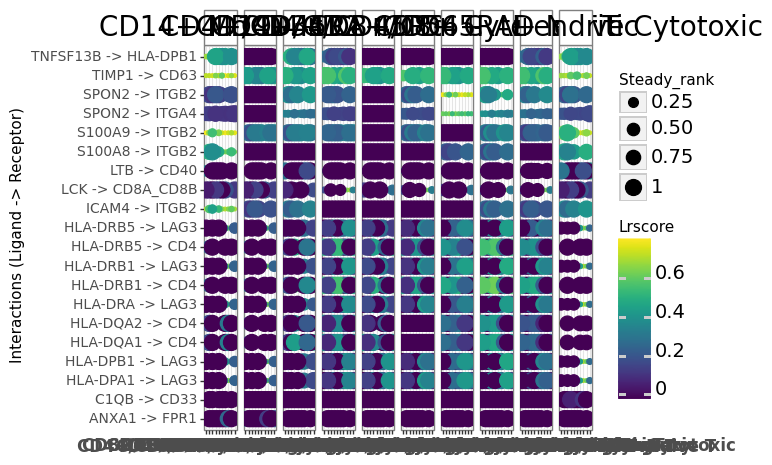

<ggplot: (8772714129960)>

In [50]:
p

In [ ]:
my_p.draw